# 🔬 Hard-Concrete / L0 Gate — Hyperspectral Band Selection

## Mục tiêu
Tìm ra **Top-K bands** quan trọng nhất trong 125 bands hyperspectral bằng phương pháp **Hard-Concrete gate** kết hợp **L0 regularization**.

---

## Tại sao không dùng Sigmoid Gate?

| | Sigmoid Gate | Hard-Concrete Gate |
|---|---|---|
| Gate values | Liên tục $(0, 1)$, **không bao giờ = 0** | Có thể **chính xác = 0 hoặc 1** |
| Sparsity | Ép bằng penalty gián tiếp → gate giảm đều | L0 penalty = **đếm #bands bật** → sparse thực sự |
| Gradient | Vanishing gradient ở gần 0 và 1 | Reparameterization trick → gradient luôn chạy |
| Kết quả thực tế | Gate đều ~0.25, không phân biệt band | Gate rõ ràng: **0 (tắt) vs 1 (bật)** |

---

## Hard-Concrete Distribution (Louizos et al., ICLR 2018)

### Công thức TRAIN (stochastic):

$$u \sim \text{Uniform}(0, 1)$$
$$s = \sigma\!\left(\frac{\log u - \log(1-u) + \log\alpha}{\beta}\right)$$
$$\bar{s} = s \cdot (\zeta - \gamma) + \gamma$$
$$z = \min(1,\; \max(0,\; \bar{s}))$$

### Công thức EVAL (deterministic):

$$z = \min\!\left(1,\; \max\!\left(0,\; \sigma(\log\alpha) \cdot (\zeta - \gamma) + \gamma\right)\right)$$

### L0 Regularization:

$$\mathcal{L}_{L0} = \sum_{i=1}^{C} \sigma\!\left(\log\alpha_i - \beta \cdot \log\frac{-\gamma}{\zeta}\right)$$

### Ý nghĩa tham số:
- $\log\alpha_i$ : **learnable** (1 per band) — quyết định band on/off
- $\beta = 2/3$ : temperature (cố định)
- $\gamma = -0.1,\; \zeta = 1.1$ : stretch interval → clamp tạo exact 0/1
- $\lambda_{L0}$ : trọng số regularization — càng lớn → càng ít band được giữ

In [30]:
import os
import random
from pathlib import Path
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tifffile as tiff
import torchvision.models as models
import torch.optim as optim
import pandas as pd
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# ===== PATHS =====
HS_DIR       = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\train\HS"
TEST_HS_DIR  = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\val\HS"
CHECKPOINT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints"
CKPT_PATH    = os.path.join(CHECKPOINT_DIR, "best_hs125_resnet18_hardconcrete.pth")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ===== DATA =====
TARGET_BANDS = 125
TARGET_HW    = (64, 64)

# ===== SPLIT =====
SEED = 42

# ===== TRAIN =====
EPOCHS     = 50            # tăng lên để có thời gian hội tụ sau warmup
BATCH_SIZE = 32
LR         = 1e-4          # backbone
GATE_LR    = 5e-3          # log_alpha — giảm từ 1e-2 để gate thay đổi từ từ hơn
WD         = 0.1
NUM_WORKERS = 0

# ===== HARD-CONCRETE =====
LAMBDA_L0       = 0.01     # ⬇️ giảm từ 0.1 → 0.01 (tránh gate collapse)
TARGET_K        = 20       # số band mục tiêu giữ lại
WARMUP_EPOCHS   = 10       # số epoch đầu: CHỈ train backbone, gate bị FREEZE
RAMPUP_EPOCHS   = 10       # số epoch tiếp: tăng dần lambda_l0 từ 0 → LAMBDA_L0
LOG_ALPHA_INIT  = 2.0      # init log_alpha = +2 → tất cả band bắt đầu BẬT
GATE_GRAD_CLIP  = 1.0      # gradient clipping cho log_alpha
GATE_NOISE_STD  = 0.5      # noise thêm vào log_alpha khi unfreeze (phá vỡ symmetry)

print(f"✓ Config loaded")
print(f"  LAMBDA_L0={LAMBDA_L0}, TARGET_K={TARGET_K}")
print(f"  WARMUP_EPOCHS={WARMUP_EPOCHS} (gate FROZEN), RAMPUP_EPOCHS={RAMPUP_EPOCHS}")
print(f"  LOG_ALPHA_INIT={LOG_ALPHA_INIT} → sigmoid ≈ {torch.sigmoid(torch.tensor(LOG_ALPHA_INIT)).item():.3f}")
print(f"  GATE_NOISE_STD={GATE_NOISE_STD} (added at unfreeze to break symmetry)")
print(f"  GATE_LR={GATE_LR}, GATE_GRAD_CLIP={GATE_GRAD_CLIP}")
print(f"  EPOCHS={EPOCHS}")

Device: cuda
✓ Config loaded
  LAMBDA_L0=0.01, TARGET_K=20
  WARMUP_EPOCHS=10 (gate FROZEN), RAMPUP_EPOCHS=10
  LOG_ALPHA_INIT=2.0 → sigmoid ≈ 0.881
  GATE_NOISE_STD=0.5 (added at unfreeze to break symmetry)
  GATE_LR=0.005, GATE_GRAD_CLIP=1.0
  EPOCHS=50


In [20]:
# ===== REPRODUCIBILITY =====
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✓ Seed set to {seed}")

set_seed(SEED)

✓ Seed set to 42


In [21]:
# ===============================================================
# Utility functions: CHW conversion, band fixing, clipping, stats
# ===============================================================

def ensure_chw(arr: np.ndarray, expected_bands: int) -> np.ndarray:
    """Đảm bảo array có dạng (C, H, W)."""
    if arr.ndim == 2:
        return arr[None, :, :]
    if arr.ndim != 3:
        raise ValueError(f"Expected 2-D or 3-D, got {arr.ndim}-D")

    d0, d1, d2 = arr.shape
    if d2 == expected_bands and d0 != expected_bands:
        return np.transpose(arr, (2, 0, 1))
    if d0 == expected_bands and d2 != expected_bands:
        return arr
    if d0 == expected_bands and d2 == expected_bands:
        return arr
    dims = [d0, d1, d2]
    c_axis = int(np.argmin(dims))
    if c_axis == 2:
        return np.transpose(arr, (2, 0, 1))
    elif c_axis == 1:
        return np.transpose(arr, (1, 0, 2))
    return arr


def fix_bands(arr: np.ndarray, target_bands: int) -> np.ndarray:
    """Cắt hoặc pad bands về target_bands."""
    c = arr.shape[0]
    if c > target_bands:
        return arr[:target_bands]
    if c < target_bands:
        pad = np.repeat(arr.mean(axis=0, keepdims=True), target_bands - c, axis=0).astype(arr.dtype)
        return np.concatenate([arr, pad], axis=0)
    return arr


def clip_per_band(x: torch.Tensor, ql=0.01, qh=0.99) -> torch.Tensor:
    """Clip mỗi band theo quantile. Input/output: (C, H, W)."""
    C = x.shape[0]
    flat = x.view(C, -1)
    lo = torch.quantile(flat, ql, dim=1).view(-1, 1, 1)
    hi = torch.quantile(flat, qh, dim=1).view(-1, 1, 1)
    return torch.clamp(x, lo, hi)


def label_from_filename(fname: str) -> str:
    return os.path.basename(fname).split("_")[0]


@torch.no_grad()
def compute_global_stats_matched(img_dir, file_list, target_bands=125,
                                  target_hw=(64, 64), clip_q=(0.01, 0.99), eps=1e-8):
    """Tính mean/std per-band trên toàn bộ file_list (matching pipeline)."""
    ql, qh = clip_q
    sum_c   = torch.zeros(target_bands, dtype=torch.float64)
    sumsq_c = torch.zeros(target_bands, dtype=torch.float64)
    count   = 0

    for fname in tqdm(file_list, desc="Computing stats"):
        path = os.path.join(img_dir, fname)
        arr = tiff.imread(path).astype(np.float32)
        arr = ensure_chw(arr, target_bands)
        arr = fix_bands(arr, target_bands)
        x = torch.from_numpy(arr)
        if x.shape[1:] != target_hw:
            x = F.interpolate(x.unsqueeze(0), size=target_hw,
                              mode="bilinear", align_corners=False).squeeze(0)
        x = clip_per_band(x, ql, qh)
        sum_c   += x.sum(dim=(1, 2), dtype=torch.float64)
        sumsq_c += (x * x).sum(dim=(1, 2), dtype=torch.float64)
        count   += x.shape[1] * x.shape[2]

    mean = (sum_c / (count + eps)).to(torch.float32)
    var  = (sumsq_c / (count + eps) - mean.double()**2).clamp_min(0.0).to(torch.float32)
    std  = torch.sqrt(var + eps)
    return mean.cpu().numpy(), std.cpu().numpy()

print("✓ Utility functions defined")

✓ Utility functions defined


In [22]:
# ===============================================================
# HSDataset — pipeline giống notebook gốc
# ===============================================================
class HSDataset(Dataset):
    """
    Hyperspectral Dataset.
    Pipeline: load → ensure_chw → fix_bands → resize → clip_per_band → z-score → augment
    """
    def __init__(self, img_dir, file_list=None, target_bands=125, target_hw=(64, 64),
                 augment=False, mean=None, std=None):
        self.img_dir = img_dir
        self.target_bands = target_bands
        self.target_hw = target_hw
        self.augment = augment

        self.mean = (torch.tensor(mean).view(target_bands, 1, 1).float()
                     if mean is not None else torch.zeros(target_bands, 1, 1))
        self.std  = (torch.tensor(std).view(target_bands, 1, 1).float()
                     if std is not None else torch.ones(target_bands, 1, 1))

        if file_list is not None:
            self.files = file_list
        else:
            self.files = sorted([f for f in os.listdir(img_dir)
                                 if f.lower().endswith((".tif", ".tiff"))])

        labels = sorted({label_from_filename(f) for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(labels)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.y = [self.class_to_idx[label_from_filename(f)] for f in self.files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.y[idx]
        path  = os.path.join(self.img_dir, fname)

        arr = tiff.imread(path).astype(np.float32)
        if arr.ndim != 3:
            raise ValueError(f"Invalid shape {arr.shape} | {fname}")

        if arr.shape[2] in (125, 126):
            arr = np.transpose(arr, (2, 0, 1))
        elif arr.shape[0] in (125, 126):
            pass
        else:
            raise ValueError(f"Cannot infer channel dim: {arr.shape} | {fname}")

        C, H, W = arr.shape
        if C == 126:   arr = arr[:125]
        elif C < 125:
            pad_c = 125 - C
            mean_band = arr.mean(axis=(1, 2), keepdims=True).mean(axis=0)
            arr = np.concatenate([arr, np.repeat(mean_band, pad_c, axis=0)], axis=0)
        elif C > 125:  arr = arr[:125]

        x = torch.from_numpy(arr)
        if x.shape[1:] != self.target_hw:
            x = F.interpolate(x.unsqueeze(0), size=self.target_hw,
                              mode="bilinear", align_corners=False).squeeze(0)

        x = clip_per_band(x, 0.01, 0.99)
        x = (x - self.mean) / (self.std + 1e-8)

        if self.augment:
            if torch.rand(1) > 0.5: x = torch.flip(x, dims=[2])
            if torch.rand(1) > 0.5: x = torch.flip(x, dims=[1])
            k = torch.randint(0, 4, (1,)).item()
            x = torch.rot90(x, k, dims=[1, 2])

        return x, label

print("✓ HSDataset defined")

✓ HSDataset defined


In [23]:
# ===============================================================
# Load shared split + compute stats + create DataLoader
# ===============================================================
SPLIT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\Notebooks\split\splits"

df_master = pd.read_csv(os.path.join(SPLIT_DIR, "samples_master.csv"))
train_idx_shared = np.load(os.path.join(SPLIT_DIR, "train_idx.npy"))
val_idx_shared   = np.load(os.path.join(SPLIT_DIR, "val_idx.npy"))

df_train = df_master.iloc[train_idx_shared].reset_index(drop=True)
df_val   = df_master.iloc[val_idx_shared].reset_index(drop=True)

train_files = [os.path.basename(p) for p in df_train["hs_path"]]
val_files   = [os.path.basename(p) for p in df_val["hs_path"]]

print(f"Split: Train={len(train_files)} | Val={len(val_files)}")

# Verify
missing = [f for f in train_files + val_files if not os.path.exists(os.path.join(HS_DIR, f))]
print(f"Missing files: {len(missing)}" if missing else "✓ All files exist")

Split: Train=461 | Val=116
✓ All files exist


In [24]:
# ===== Tính global stats trên TRAIN =====
print("Calculating stats (TRAIN only)...")
mean_stats, std_stats = compute_global_stats_matched(
    HS_DIR, train_files,
    target_bands=TARGET_BANDS, target_hw=TARGET_HW, clip_q=(0.01, 0.99)
)
print(f"Mean[0:5]: {mean_stats[:5]}")
print(f"Std [0:5]: {std_stats[:5]}")

Calculating stats (TRAIN only)...


Computing stats: 100%|██████████| 461/461 [00:11<00:00, 39.41it/s]

Mean[0:5]: [581.4699  626.0004  649.4432  662.0995  669.45667]
Std [0:5]: [1885.0404 1878.6755 1874.7366 1871.2903 1868.411 ]


In [25]:
# ===== Dataset + DataLoader =====
train_ds = HSDataset(HS_DIR, file_list=train_files,
                     target_bands=TARGET_BANDS, target_hw=TARGET_HW,
                     augment=True, mean=mean_stats, std=std_stats)

val_ds = HSDataset(HS_DIR, file_list=val_files,
                   target_bands=TARGET_BANDS, target_hw=TARGET_HW,
                   augment=False, mean=mean_stats, std=std_stats)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

num_classes = len(train_ds.class_to_idx)
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Classes: {num_classes}")
print(f"Class mapping: {train_ds.class_to_idx}")

xb, yb = next(iter(train_loader))
print(f"Batch shape: {xb.shape}")  # [B, 125, 64, 64]

Train: 461 | Val: 116 | Classes: 3
Class mapping: {'Health': 0, 'Other': 1, 'Rust': 2}
Batch shape: torch.Size([32, 125, 64, 64])


---
## 🧠 Model: HardConcreteGatedResNet18

### Kiến trúc:
```
Input (B, 125, 64, 64)
    │
    ▼
┌─────────────────────────────────┐
│  Hard-Concrete Gate             │
│  log_alpha: (125,) learnable    │
│                                 │
│  TRAIN: sample z ~ HC(log_α)   │
│  EVAL:  z = clamp(σ(log_α)·Δ)  │ ──→ z ∈ {0, ..., 1}  (125,)
│                                 │
│  x = x * z.view(1, -1, 1, 1)   │
└─────────────────────────────────┘
    │
    ▼
┌─────────────────────────────────┐
│  ResNet18 (pretrained)          │
│  conv1: (125 → 64, 7×7)        │
│  ... standard ResNet ...        │
│  fc: (512 → num_classes)        │
└─────────────────────────────────┘
    │
    ▼
Output: logits (B, num_classes)
```

### Tham số Hard-Concrete:
- **`log_alpha`** (125,) — learnable, init = 0 → sigmoid(0) = 0.5 → tất cả band bắt đầu "nửa bật"
- **`beta = 2/3`** — temperature, nhỏ hơn → gate "cứng" hơn (nhị phân hơn)
- **`gamma = -0.1`** — cận dưới stretch → cho $\bar{s}$ có thể < 0 → clamp = 0 (tắt band)
- **`zeta = 1.1`** — cận trên stretch → cho $\bar{s}$ có thể > 1 → clamp = 1 (bật band)

### L0 Loss:
Đếm **xác suất mỗi band được bật** (xác suất $z_i > 0$):

$$P(z_i > 0) = \sigma\!\left(\log\alpha_i - \beta \cdot \log\frac{-\gamma}{\zeta}\right)$$

Minimize $\sum P(z_i > 0)$ = ép gate tắt nhiều band → **sparse selection**.

In [31]:
# ===============================================================
# HardConcreteGatedResNet18
# Ref: Louizos et al., "Learning Sparse Neural Networks through
#      L0 Regularization", ICLR 2018
#
# FIX v2: 
#   - log_alpha init = +2 (all bands start ON, sigmoid(2)≈0.88)
#   - Thêm gradient clipping utility
#   - Thêm method active counting với threshold > 0.5
# ===============================================================

class HardConcreteGatedResNet18(nn.Module):
    """
    ResNet18 với Hard-Concrete gate để chọn band.
    
    Mỗi band i có một tham số log_alpha_i (learnable).
    - Khi train: sample gate z_i từ Hard-Concrete distribution
    - Khi eval:  z_i = clamp(sigmoid(log_alpha_i) * (zeta - gamma) + gamma)
    
    L0 regularization ép nhiều z_i = 0 (tắt band).
    
    FIX: Init log_alpha dương → sigmoid(log_alpha) ≈ 1 → tất cả band bắt đầu BẬT.
    L0 penalty sẽ từ từ tắt bớt band — giữ lại ~TARGET_K band quan trọng nhất.
    """
    
    # --- Hard-Concrete hyperparameters (cố định) ---
    BETA  = 2.0 / 3.0   # temperature
    GAMMA = -0.1         # stretch lower bound (< 0 để cho phép clamp = 0)
    ZETA  = 1.1          # stretch upper bound (> 1 để cho phép clamp = 1)
    EPS   = 1e-8         # tránh log(0)
    
    def __init__(self, num_bands=125, num_classes=3, log_alpha_init=2.0):
        super().__init__()
        
        # ====== Gate parameters ======
        # FIX: Init log_alpha = +2.0 → sigmoid(2) ≈ 0.88
        # Tất cả band bắt đầu ở trạng thái BẬT (gate ≈ 0.95)
        # L0 penalty sẽ dần dần tắt bớt band không quan trọng
        self.log_alpha = nn.Parameter(torch.full((num_bands,), log_alpha_init))
        
        # ====== Backbone: ResNet18 pretrained ======
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Sửa conv1 để nhận num_bands channels (thay vì 3 RGB)
        old_conv = base.conv1
        base.conv1 = nn.Conv2d(
            num_bands, old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )
        # Init: lấy mean weight RGB rồi replicate
        with torch.no_grad():
            base.conv1.weight[:] = (
                old_conv.weight.mean(dim=1, keepdim=True)
                .repeat(1, num_bands, 1, 1)
            )
        
        # Sửa fc head
        base.fc = nn.Linear(base.fc.in_features, num_classes)
        self.backbone = base
    
    # ----------------------------------------------------------
    #  Hard-Concrete sampling (chỉ dùng khi TRAIN)
    # ----------------------------------------------------------
    def _hard_concrete_sample(self) -> torch.Tensor:
        """
        Sample z từ Hard-Concrete distribution.
        
        Các bước:
        1. u ~ Uniform(0, 1)
        2. s = sigmoid((log(u) - log(1-u) + log_alpha) / beta)    ← Binary Concrete
        3. s_bar = s * (zeta - gamma) + gamma                      ← Stretch
        4. z = clamp(s_bar, 0, 1)                                  ← Hard clamp
        
        Returns: z (num_bands,) — gate values trong [0, 1], CÓ THỂ chính xác = 0 hoặc 1
        """
        # 1. Sample u ~ Uniform(EPS, 1-EPS) — tránh log(0)
        u = torch.zeros_like(self.log_alpha).uniform_(self.EPS, 1.0 - self.EPS)
        
        # 2. Binary Concrete: s = sigmoid((logit(u) + log_alpha) / beta)
        #    logit(u) = log(u) - log(1-u)
        s = torch.sigmoid(
            (torch.log(u) - torch.log(1.0 - u) + self.log_alpha) / self.BETA
        )
        
        # 3. Stretch ra ngoài [0, 1]
        s_bar = s * (self.ZETA - self.GAMMA) + self.GAMMA
        
        # 4. Hard clamp → cho phép exact 0 và exact 1
        z = torch.clamp(s_bar, min=0.0, max=1.0)
        
        return z
    
    # ----------------------------------------------------------
    #  Deterministic gate (dùng khi EVAL)
    # ----------------------------------------------------------
    def _hard_concrete_deterministic(self) -> torch.Tensor:
        """
        Gate xác định (không random).
        z = clamp(sigmoid(log_alpha) * (zeta - gamma) + gamma, 0, 1)
        """
        s = torch.sigmoid(self.log_alpha)
        s_bar = s * (self.ZETA - self.GAMMA) + self.GAMMA
        return torch.clamp(s_bar, min=0.0, max=1.0)
    
    # ----------------------------------------------------------
    #  L0 Regularization
    # ----------------------------------------------------------
    def l0_regularization(self) -> torch.Tensor:
        """
        L0 = sum P(z_i != 0) cho mỗi band i
        
        P(z_i != 0) = sigmoid(log_alpha_i - beta * log(-gamma / zeta))
        
        Minimize L0 → ép nhiều band tắt (z_i = 0)
        """
        # log(-gamma / zeta) = log(0.1 / 1.1) ≈ -2.3979
        return torch.sigmoid(
            self.log_alpha - self.BETA * torch.log(torch.tensor(-self.GAMMA / self.ZETA))
        ).sum()
    
    # ----------------------------------------------------------
    #  Forward
    # ----------------------------------------------------------
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C, H, W)
        
        Training:  z ~ Hard-Concrete (stochastic)
        Eval:      z = deterministic
        """
        if self.training:
            z = self._hard_concrete_sample()        # (C,) — có noise
        else:
            z = self._hard_concrete_deterministic()  # (C,) — xác định
        
        # Nhân gate vào input
        x = x * z.view(1, -1, 1, 1)
        
        return self.backbone(x)
    
    # ----------------------------------------------------------
    #  Tiện ích
    # ----------------------------------------------------------
    def gate(self) -> torch.Tensor:
        """Trả về deterministic gate values (dùng để phân tích top-K)."""
        return self._hard_concrete_deterministic().detach()
    
    def num_active_bands(self, threshold=0.5) -> int:
        """Đếm số band có gate > threshold (deterministic)."""
        return (self.gate() > threshold).sum().item()
    
    def get_topk_bands(self, k: int = 20):
        """Trả về indices và values của top-K bands."""
        g = self.gate().cpu().numpy()
        sorted_idx = np.argsort(g)[::-1]
        topk_idx = sorted_idx[:k]
        topk_vals = g[topk_idx]
        return topk_idx, topk_vals

print("✓ HardConcreteGatedResNet18 defined (v2: positive init, gradient clip support)")

✓ HardConcreteGatedResNet18 defined (v2: positive init, gradient clip support)


In [32]:
# ===============================================================
# Khởi tạo model, optimizer, scheduler (v2)
# ===============================================================
set_seed(SEED)

model = HardConcreteGatedResNet18(
    num_bands=TARGET_BANDS,
    num_classes=num_classes,
    log_alpha_init=LOG_ALPHA_INIT,   # ← tất cả band bắt đầu BẬT
).to(device)

criterion = nn.CrossEntropyLoss()

# Tách optimizer: lr cao cho gate, lr thấp cho backbone
gate_params  = [model.log_alpha]
other_params = [p for n, p in model.named_parameters() if n != "log_alpha"]

optimizer = optim.AdamW([
    {"params": other_params, "lr": LR,       "weight_decay": WD},
    {"params": gate_params,  "lr": GATE_LR,  "weight_decay": 0.0},  # không WD cho gate
])

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# --- Kiểm tra init ---
init_gate = model.gate().cpu()

print(f"Model on: {next(model.parameters()).device}")
print(f"Backbone lr={LR}, Gate lr={GATE_LR}")
print(f"L0 lambda={LAMBDA_L0}, Target K={TARGET_K}")
print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")
print(f"Gate params:  {model.log_alpha.numel()}")
print(f"\n--- Initial gate check ---")
print(f"  log_alpha init: {model.log_alpha.data.mean():.2f} (should be {LOG_ALPHA_INIT})")
print(f"  gate mean={init_gate.mean():.4f}, min={init_gate.min():.4f}, max={init_gate.max():.4f}")
print(f"  active (>0.5): {(init_gate > 0.5).sum().item()} / {TARGET_BANDS}")
print(f"  → All bands start ON ✓" if (init_gate > 0.5).sum().item() == TARGET_BANDS else "  ⚠️ NOT all bands ON!")

✓ Seed set to 42
Model on: cuda:0
Backbone lr=0.0001, Gate lr=0.005
L0 lambda=0.01, Target K=20
Total params: 11,560,768
Gate params:  125

--- Initial gate check ---
  log_alpha init: 2.00 (should be 2.0)
  gate mean=0.9570, min=0.9570, max=0.9570
  active (>0.5): 125 / 125
  → All bands start ON ✓


---
## 🏋️ Training Loop (v2 — Anti-Collapse Strategy)

### Loss function:

$$\mathcal{L} = \mathcal{L}_{CE} + \lambda(t) \cdot \mathcal{L}_{L0}$$

### 3-Phase Training Schedule:

| Phase | Epochs | $\lambda(t)$ | Mục đích |
|-------|--------|------------|----------|
| **Warmup** | 1 → WARMUP | 0 | Backbone học features từ TẤT CẢ bands |
| **Ramp-up** | WARMUP+1 → WARMUP+RAMPUP | $0 \to \lambda_{max}$ tuyến tính | Gate bắt đầu PHÂN HÓA |
| **Full** | còn lại | $\lambda_{max}$ | Gate ổn định, ~TARGET_K bands active |

### Chống gate collapse:
1. **Init log_alpha = +2** → sigmoid(2) ≈ 0.88 → gate ≈ 0.95 → tất cả band BẬT
2. **Warmup** → backbone đủ mạnh trước khi gate bắt đầu tắt band
3. **Ramp-up** → L0 tăng từ từ, gradient phân hóa → band quan trọng giữ lại, band dư bị tắt
4. **Gradient clipping** → log_alpha không nhảy quá nhanh

### Monitoring:
- **active** (gate > 0.5): bands thực sự bật → mong muốn giảm about TARGET_K
- **dead** (gate < 0.01): bands đã tắt hoàn toàn
- **partial** (0.01 ≤ gate ≤ 0.5): bands đang "quyết định" → nên giảm dần
- **gate_std**: phải TĂNG dần = gate đang phân hóa tốt

In [33]:
# ===============================================================
# Training + Evaluation functions (v2: warmup + gradient clipping)
# ===============================================================

def get_current_lambda(epoch, warmup_epochs, rampup_epochs, lambda_l0_max):
    """
    Warmup schedule cho lambda_l0:
    - epoch 1..warmup_epochs:   λ = 0 (chỉ train backbone, gate tự do)
    - epoch warmup+1..warmup+rampup: λ tăng tuyến tính 0 → λ_max
    - epoch > warmup+rampup:    λ = λ_max
    """
    if epoch <= warmup_epochs:
        return 0.0
    elif epoch <= warmup_epochs + rampup_epochs:
        progress = (epoch - warmup_epochs) / rampup_epochs
        return lambda_l0_max * progress
    else:
        return lambda_l0_max


def train_one_epoch(model, loader, optimizer, criterion, lambda_l0, device,
                    gate_grad_clip=1.0):
    model.train()
    total_loss, total_ce, total_l0 = 0.0, 0.0, 0.0
    correct, total = 0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        out = model(x)
        ce_loss = criterion(out, y)
        l0_loss = model.l0_regularization()
        
        loss = ce_loss + lambda_l0 * l0_loss
        
        loss.backward()
        
        # FIX: Gradient clipping cho log_alpha để tránh collapse
        if gate_grad_clip > 0 and model.log_alpha.grad is not None:
            torch.nn.utils.clip_grad_norm_([model.log_alpha], gate_grad_clip)
        
        optimizer.step()
        
        total_loss += loss.item() * x.size(0)
        total_ce   += ce_loss.item() * x.size(0)
        total_l0   += l0_loss.item() * x.size(0)
        correct    += (out.argmax(1) == y).sum().item()
        total      += x.size(0)
    
    return {
        "loss":     total_loss / total,
        "ce_loss":  total_ce / total,
        "l0_loss":  total_l0 / total,
        "acc":      correct / total,
    }


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item() * x.size(0)
        correct    += (out.argmax(1) == y).sum().item()
        total      += x.size(0)
    
    return {
        "loss": total_loss / total,
        "acc":  correct / total,
    }


def get_gate_stats(model):
    """
    Lấy thống kê gate hiện tại (v2: threshold có ý nghĩa).
    
    - active:  gate > 0.5  (band thực sự bật)
    - dead:    gate < 0.01 (band gần như tắt hoàn toàn)
    - partial: 0.01 <= gate <= 0.5 (band "nửa sống nửa chết")
    """
    with torch.no_grad():
        g = model.gate().cpu()
    return {
        "sum":      g.sum().item(),
        "mean":     g.mean().item(),
        "std":      g.std().item(),
        "min":      g.min().item(),
        "max":      g.max().item(),
        "active":   (g > 0.5).sum().item(),     # bands thực sự BẬT  
        "dead":     (g < 0.01).sum().item(),     # bands gần như TẮT  
        "partial":  ((g >= 0.01) & (g <= 0.5)).sum().item(),  # vùng trung gian
    }

print("✓ Train/eval functions defined (v2: warmup scheduler, gradient clipping, better gate stats)")

✓ Train/eval functions defined (v2: warmup scheduler, gradient clipping, better gate stats)


In [34]:
# ===============================================================
# 🏋️ TRAINING LOOP (v3: Gate FROZEN in warmup → Unfreeze + Noise)
# ===============================================================
# 
# Tại sao gate_sum đứng yên trong warmup v2?
#   - λ=0 → không có L0 gradient đẩy gate thay đổi
#   - log_alpha=2.0 → sigmoid(2)≈0.88 → ~60% samples bị clamp tại 1.0
#   - Gradient qua clamp(..., max=1.0) = 0 → CE gradient trên gate ≈ 0
#
# FIX v3:
#   Phase 1 (warmup): gate FROZEN (requires_grad=False)
#     → Backbone học features từ TẤT CẢ bands, không lãng phí optimizer state
#
#   Phase 2 (ramp-up start): UNFREEZE + thêm N(0, GATE_NOISE_STD) noise
#     → Phá vỡ symmetry: mỗi band bắt đầu ở 1 vị trí khác nhau
#     → L0 gradient + CE gradient cùng tác động → gate PHÂN HÓA
#     → Bands quan trọng: CE gradient giữ gate cao (chống lại L0)
#     → Bands không quan trọng: CE gradient yếu → L0 đẩy gate → 0
#
#   Phase 3 (full): λ=LAMBDA_L0, gate tiếp tục hội tụ
# ===============================================================

best_acc   = -1.0
best_epoch = -1
history    = []

# ⛔ FREEZE gate trong warmup — chỉ train backbone
model.log_alpha.requires_grad_(False)

print(f"{'='*100}")
print(f"  Training HardConcreteGatedResNet18 v3 | {EPOCHS} epochs")
print(f"  Phase 1: Warmup {WARMUP_EPOCHS}ep (gate FROZEN, λ=0)")
print(f"  Phase 2: Ramp-up {RAMPUP_EPOCHS}ep (gate UNFROZEN + noise, λ: 0→{LAMBDA_L0})")
print(f"  Phase 3: Full (λ={LAMBDA_L0})")
print(f"{'='*100}")

for epoch in range(1, EPOCHS + 1):
    # ============================================================
    # 🔓 Transition: warmup → ramp-up (unfreeze gate + add noise)
    # ============================================================
    if epoch == WARMUP_EPOCHS + 1:
        model.log_alpha.requires_grad_(True)
        
        # Thêm noise phá vỡ symmetry
        with torch.no_grad():
            noise = torch.randn_like(model.log_alpha) * GATE_NOISE_STD
            model.log_alpha.add_(noise)
        
        gs_init = get_gate_stats(model)
        la = model.log_alpha.detach().cpu()
        print(f"\n  {'='*80}")
        print(f"  🔓 GATE UNFROZEN + noise(std={GATE_NOISE_STD}) added")
        print(f"    log_alpha: [{la.min():.3f}, {la.max():.3f}], std={la.std():.4f}")
        print(f"    gate: sum={gs_init['sum']:.1f}, std={gs_init['std']:.4f}")
        print(f"    active={gs_init['active']}, partial={gs_init['partial']}, dead={gs_init['dead']}")
        print(f"  {'='*80}\n")
    
    # --- Compute current lambda_l0 ---
    current_lambda = get_current_lambda(epoch, WARMUP_EPOCHS, RAMPUP_EPOCHS, LAMBDA_L0)
    
    # --- Phase label ---
    if epoch <= WARMUP_EPOCHS:
        phase = "WARMUP"
    elif epoch <= WARMUP_EPOCHS + RAMPUP_EPOCHS:
        phase = "RAMP-UP"
    else:
        phase = "FULL"
    
    # --- Train ---
    train_metrics = train_one_epoch(
        model, train_loader, optimizer, criterion, 
        lambda_l0=current_lambda, 
        device=device,
        gate_grad_clip=GATE_GRAD_CLIP
    )
    
    # --- Eval ---
    val_metrics = evaluate(model, val_loader, criterion, device)
    
    # --- Scheduler step ---
    scheduler.step()
    
    # --- Gate stats ---
    gs = get_gate_stats(model)
    
    # --- Log ---
    history.append({
        "epoch": epoch,
        "phase": phase,
        "lambda_l0": current_lambda,
        **{f"train_{k}": v for k, v in train_metrics.items()},
        **{f"val_{k}": v for k, v in val_metrics.items()},
        **{f"gate_{k}": v for k, v in gs.items()},
    })
    
    print(
        f"[{phase:>7s}] Epoch {epoch:02d}/{EPOCHS} | λ={current_lambda:.4f} | "
        f"Train: {train_metrics['acc']:.4f} | Val: {val_metrics['acc']:.4f} | "
        f"CE={train_metrics['ce_loss']:.4f} L0={train_metrics['l0_loss']:.1f} | "
        f"active={gs['active']:3d} dead={gs['dead']:3d} partial={gs['partial']:3d} | "
        f"gate: sum={gs['sum']:.1f} std={gs['std']:.3f} [{gs['min']:.3f}, {gs['max']:.3f}]"
    )
    
    # --- Save best ---
    if val_metrics['acc'] > best_acc:
        best_acc   = val_metrics['acc']
        best_epoch = epoch
        
        ckpt = {
            "epoch":       epoch,
            "best_acc":    best_acc,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "gate_stats":  gs,
            "config": {
                "EPOCHS": EPOCHS, "LR": LR, "GATE_LR": GATE_LR,
                "WD": WD, "LAMBDA_L0": LAMBDA_L0, "TARGET_K": TARGET_K,
                "WARMUP_EPOCHS": WARMUP_EPOCHS, "RAMPUP_EPOCHS": RAMPUP_EPOCHS,
                "LOG_ALPHA_INIT": LOG_ALPHA_INIT, "GATE_GRAD_CLIP": GATE_GRAD_CLIP,
                "GATE_NOISE_STD": GATE_NOISE_STD,
            },
        }
        torch.save(ckpt, CKPT_PATH)
        print(f"  ✅ BEST @epoch {epoch} | acc={best_acc:.4f} → {CKPT_PATH}")

print(f"\n{'='*100}")
print(f"  Done. Best Val Acc = {best_acc:.4f} at epoch {best_epoch}")
print(f"{'='*100}")

  Training HardConcreteGatedResNet18 v3 | 50 epochs
  Phase 1: Warmup 10ep (gate FROZEN, λ=0)
  Phase 2: Ramp-up 10ep (gate UNFROZEN + noise, λ: 0→0.01)
  Phase 3: Full (λ=0.01)
[ WARMUP] Epoch 01/50 | λ=0.0000 | Train: 0.4837 | Val: 0.5172 | CE=1.1130 L0=121.7 | active=125 dead=  0 partial=  0 | gate: sum=119.6 std=0.000 [0.957, 0.957]
  ✅ BEST @epoch 1 | acc=0.5172 → D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs125_resnet18_hardconcrete.pth
[ WARMUP] Epoch 02/50 | λ=0.0000 | Train: 0.6074 | Val: 0.5517 | CE=0.8621 L0=121.7 | active=125 dead=  0 partial=  0 | gate: sum=119.6 std=0.000 [0.957, 0.957]
  ✅ BEST @epoch 2 | acc=0.5517 → D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_hs125_resnet18_hardconcrete.pth
[ WARMUP] Epoch 03/50 | λ=0.0000 | Train: 0.6377 | Val: 0.5345 | CE=0.8253 L0=121.7 | active=125 dead=  0 partial=  0 | gate: sum=119.6 std=0.000 [0.957, 0.957]
[ WARMUP] Epoch 04/50 | λ=0.0000 | Train: 0.6898 | Val: 0.5776 | CE=0.7140 L0=121.7 | active=125 

In [36]:
# Quick summary of training results
print(f"Best Val Acc: {best_acc:.4f} at epoch {best_epoch}")
print(f"Final gate stats: active={gs['active']}, partial={gs['partial']}, dead={gs['dead']}")
print(f"Gate: sum={gs['sum']:.1f}, std={gs['std']:.4f}, min={gs['min']:.4f}, max={gs['max']:.4f}")

print(f"\n--- Key transition epochs ---")
for h in history:
    if h['epoch'] in [1, 5, 10, 11, 15, 20, 21, 30, 40, 50]:
        print(f"  Epoch {h['epoch']:02d} [{h['phase']:>7s}] λ={h['lambda_l0']:.4f} | "
              f"val={h['val_acc']:.4f} | "
              f"active={h['gate_active']:3.0f} dead={h['gate_dead']:3.0f} partial={h['gate_partial']:3.0f} | "
              f"std={h['gate_std']:.4f} sum={h['gate_sum']:.1f}")

Best Val Acc: 0.6724 at epoch 30
Final gate stats: active=119, partial=6, dead=0
Gate: sum=101.8, std=0.1420, min=0.2898, max=1.0000

--- Key transition epochs ---
  Epoch 01 [ WARMUP] λ=0.0000 | val=0.5172 | active=125 dead=  0 partial=  0 | std=0.0000 sum=119.6
  Epoch 05 [ WARMUP] λ=0.0000 | val=0.5086 | active=125 dead=  0 partial=  0 | std=0.0000 sum=119.6
  Epoch 10 [ WARMUP] λ=0.0000 | val=0.5862 | active=125 dead=  0 partial=  0 | std=0.0000 sum=119.6
  Epoch 11 [RAMP-UP] λ=0.0010 | val=0.5172 | active=125 dead=  0 partial=  0 | std=0.0677 sum=116.4
  Epoch 15 [RAMP-UP] λ=0.0050 | val=0.5948 | active=125 dead=  0 partial=  0 | std=0.0743 sum=115.3
  Epoch 20 [RAMP-UP] λ=0.0100 | val=0.6293 | active=125 dead=  0 partial=  0 | std=0.0909 sum=112.6
  Epoch 21 [   FULL] λ=0.0100 | val=0.6121 | active=125 dead=  0 partial=  0 | std=0.0950 sum=111.9
  Epoch 30 [   FULL] λ=0.0100 | val=0.6724 | active=122 dead=  0 partial=  3 | std=0.1242 sum=106.0
  Epoch 40 [   FULL] λ=0.0100 | val=

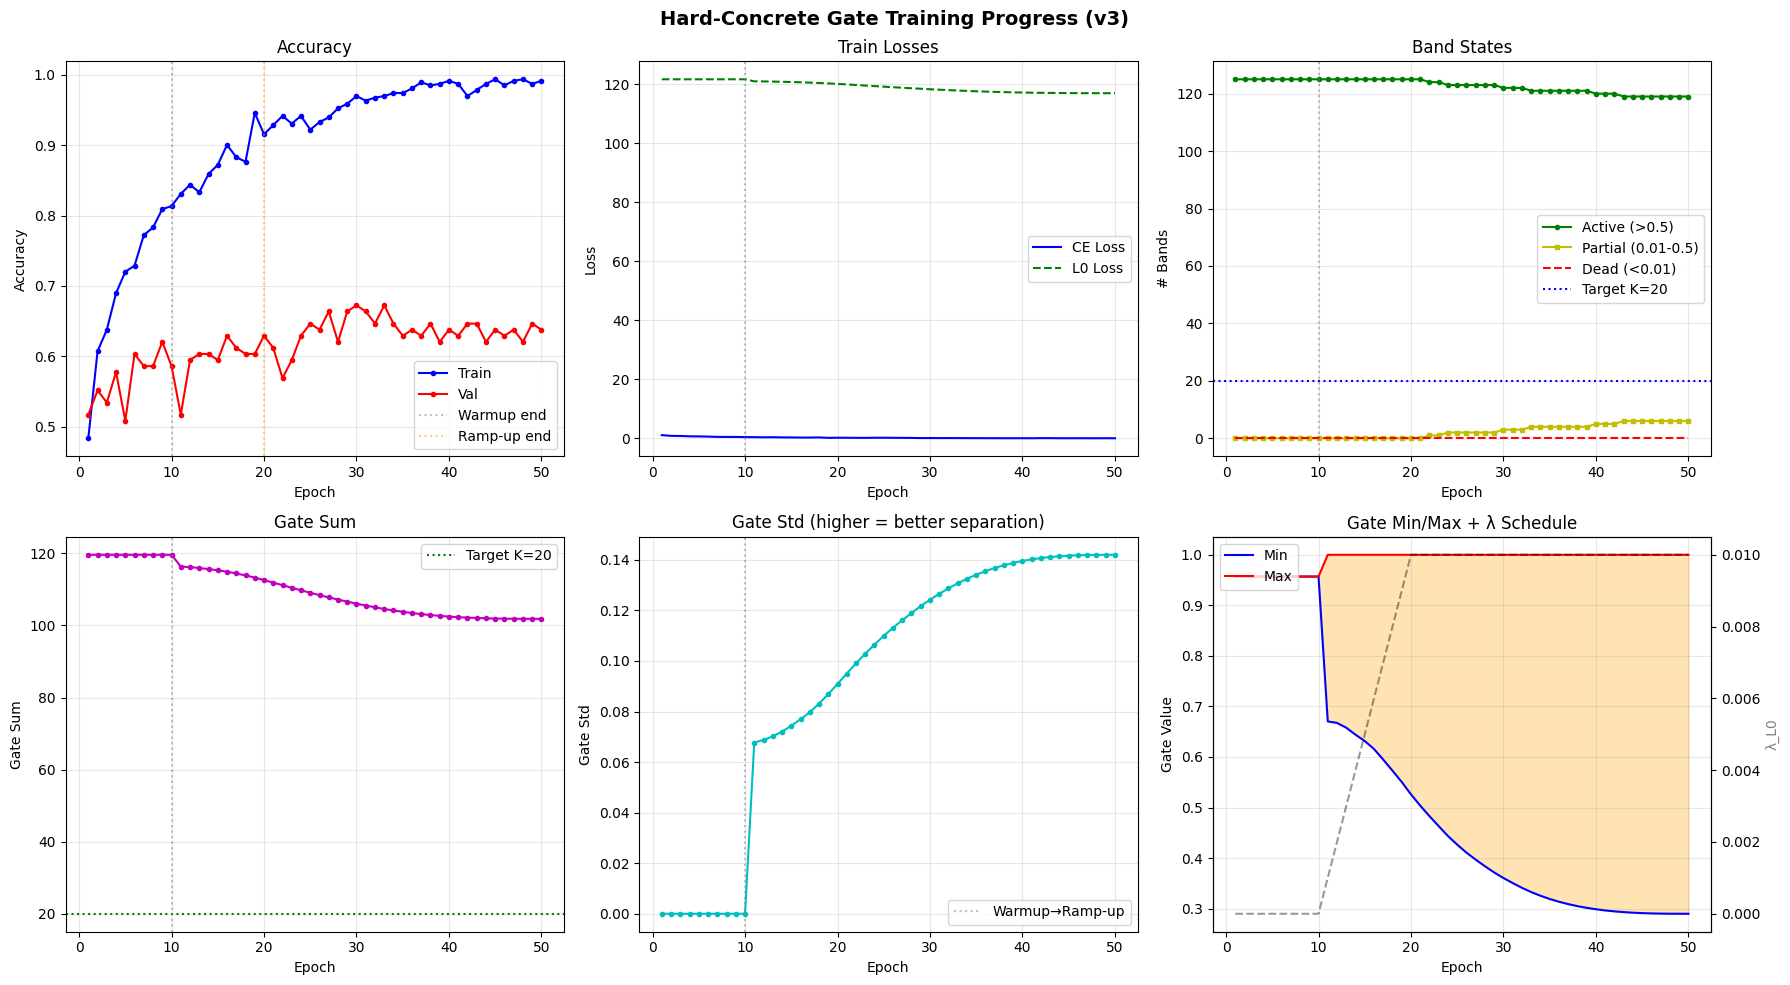

📊 History plot saved


In [37]:
# ===============================================================
# 📊 Training History Visualization
# ===============================================================
import matplotlib.pyplot as plt

df_hist = pd.DataFrame(history)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# (1) Accuracy
ax = axes[0, 0]
ax.plot(df_hist['epoch'], df_hist['train_acc'], 'b-o', markersize=3, label='Train')
ax.plot(df_hist['epoch'], df_hist['val_acc'], 'r-o', markersize=3, label='Val')
ax.axvline(x=WARMUP_EPOCHS, color='gray', linestyle=':', alpha=0.5, label='Warmup end')
ax.axvline(x=WARMUP_EPOCHS+RAMPUP_EPOCHS, color='orange', linestyle=':', alpha=0.5, label='Ramp-up end')
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy'); ax.set_title('Accuracy')
ax.legend(); ax.grid(True, alpha=0.3)

# (2) Loss (CE + L0)
ax = axes[0, 1]
ax.plot(df_hist['epoch'], df_hist['train_ce_loss'], 'b-', label='CE Loss')
ax.plot(df_hist['epoch'], df_hist['train_l0_loss'], 'g--', label='L0 Loss')
ax.axvline(x=WARMUP_EPOCHS, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.set_title('Train Losses')
ax.legend(); ax.grid(True, alpha=0.3)

# (3) Active / Partial / Dead bands
ax = axes[0, 2]
ax.plot(df_hist['epoch'], df_hist['gate_active'], 'g-o', markersize=3, label='Active (>0.5)')
if 'gate_partial' in df_hist.columns:
    ax.plot(df_hist['epoch'], df_hist['gate_partial'], 'y-s', markersize=3, label='Partial (0.01-0.5)')
ax.plot(df_hist['epoch'], df_hist['gate_dead'], 'r--', markersize=3, label='Dead (<0.01)')
ax.axhline(y=TARGET_K, color='blue', linestyle=':', label=f'Target K={TARGET_K}')
ax.axvline(x=WARMUP_EPOCHS, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Epoch'); ax.set_ylabel('# Bands'); ax.set_title('Band States')
ax.legend(); ax.grid(True, alpha=0.3)

# (4) Gate sum
ax = axes[1, 0]
ax.plot(df_hist['epoch'], df_hist['gate_sum'], 'm-o', markersize=3)
ax.axhline(y=TARGET_K, color='green', linestyle=':', label=f'Target K={TARGET_K}')
ax.axvline(x=WARMUP_EPOCHS, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Epoch'); ax.set_ylabel('Gate Sum'); ax.set_title('Gate Sum')
ax.legend(); ax.grid(True, alpha=0.3)

# (5) Gate std
ax = axes[1, 1]
ax.plot(df_hist['epoch'], df_hist['gate_std'], 'c-o', markersize=3)
ax.axvline(x=WARMUP_EPOCHS, color='gray', linestyle=':', alpha=0.5, label='Warmup→Ramp-up')
ax.set_xlabel('Epoch'); ax.set_ylabel('Gate Std'); ax.set_title('Gate Std (higher = better separation)')
ax.legend(); ax.grid(True, alpha=0.3)

# (6) Gate min/max + λ schedule
ax = axes[1, 2]
ax.fill_between(df_hist['epoch'], df_hist['gate_min'], df_hist['gate_max'], alpha=0.3, color='orange')
ax.plot(df_hist['epoch'], df_hist['gate_min'], 'b-', label='Min')
ax.plot(df_hist['epoch'], df_hist['gate_max'], 'r-', label='Max')
if 'lambda_l0' in df_hist.columns:
    ax2 = ax.twinx()
    ax2.plot(df_hist['epoch'], df_hist['lambda_l0'], 'k--', alpha=0.4, label='λ_L0')
    ax2.set_ylabel('λ_L0', color='gray')
ax.set_xlabel('Epoch'); ax.set_ylabel('Gate Value'); ax.set_title('Gate Min/Max + λ Schedule')
ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)

plt.suptitle('Hard-Concrete Gate Training Progress (v3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "hardconcrete_training_history.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"📊 History plot saved")

---
## 🔧 Phase 2: Fine-tune with stronger λ

Kết quả Phase 1: gate đã **phân hóa** (std=0.14, min=0.29, max=1.0) nhưng λ=0.01 quá nhẹ — chỉ 6 band partial, 0 dead.

**Strategy**: Tăng λ lên 0.1 (10x) và tiếp tục train từ model hiện tại. Vì backbone đã mạnh và gate đã có gradient khác nhau, L0 mạnh hơn sẽ đẩy band yếu → 0 mà không gây collapse.

In [38]:
# ===============================================================
# 🔧 Fine-tune Phase: Tăng λ để đẩy gate → sparse
# ===============================================================
# Tiếp tục train từ model hiện tại (đã có gate phân hóa)
# Tăng λ mạnh hơn → đẩy band yếu về 0, giữ band mạnh ≈ 1
# ===============================================================

FINETUNE_EPOCHS   = 40
FINETUNE_LAMBDA   = 0.1     # 10x so với phase 1
FINETUNE_LR       = 5e-5    # giảm backbone lr (đã converge)
FINETUNE_GATE_LR  = 5e-3    # giữ gate lr
FINETUNE_GRAD_CLIP = 1.0

# --- Optimizer mới cho fine-tune ---
ft_optimizer = optim.AdamW([
    {"params": other_params, "lr": FINETUNE_LR,      "weight_decay": WD},
    {"params": [model.log_alpha], "lr": FINETUNE_GATE_LR, "weight_decay": 0.0},
])
ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max=FINETUNE_EPOCHS, eta_min=1e-6)

# Đảm bảo gate unfrozen
model.log_alpha.requires_grad_(True)

ft_history = []
ft_best_acc   = best_acc  # bắt đầu từ best acc Phase 1
ft_best_epoch = -1

print(f"{'='*100}")
print(f"  Fine-tune Phase | {FINETUNE_EPOCHS} epochs | λ={FINETUNE_LAMBDA}")
print(f"  Starting from: val_acc={best_acc:.4f}, active={gs['active']}, std={gs['std']:.4f}")
print(f"{'='*100}")

for ep in range(1, FINETUNE_EPOCHS + 1):
    # --- Ramp λ in first 5 epochs of fine-tune to avoid shock ---
    if ep <= 5:
        ft_lambda = FINETUNE_LAMBDA * (ep / 5)
    else:
        ft_lambda = FINETUNE_LAMBDA
    
    train_m = train_one_epoch(
        model, train_loader, ft_optimizer, criterion,
        lambda_l0=ft_lambda, device=device,
        gate_grad_clip=FINETUNE_GRAD_CLIP
    )
    val_m = evaluate(model, val_loader, criterion, device)
    ft_scheduler.step()
    gs = get_gate_stats(model)
    
    ft_history.append({
        "epoch": ep,
        "lambda_l0": ft_lambda,
        **{f"train_{k}": v for k, v in train_m.items()},
        **{f"val_{k}": v for k, v in val_m.items()},
        **{f"gate_{k}": v for k, v in gs.items()},
    })
    
    print(
        f"FT {ep:02d}/{FINETUNE_EPOCHS} | λ={ft_lambda:.3f} | "
        f"Train: {train_m['acc']:.4f} | Val: {val_m['acc']:.4f} | "
        f"CE={train_m['ce_loss']:.4f} L0={train_m['l0_loss']:.1f} | "
        f"active={gs['active']:3d} dead={gs['dead']:3d} partial={gs['partial']:3d} | "
        f"gate: sum={gs['sum']:.1f} std={gs['std']:.3f} [{gs['min']:.3f}, {gs['max']:.3f}]"
    )
    
    if val_m['acc'] > ft_best_acc:
        ft_best_acc   = val_m['acc']
        ft_best_epoch = ep
        ckpt = {
            "epoch": ep, "best_acc": ft_best_acc,
            "model_state": model.state_dict(),
            "optimizer_state": ft_optimizer.state_dict(),
            "gate_stats": gs,
            "config": {
                "phase": "finetune", "FINETUNE_LAMBDA": FINETUNE_LAMBDA,
                "FINETUNE_LR": FINETUNE_LR, "FINETUNE_GATE_LR": FINETUNE_GATE_LR,
                "TARGET_K": TARGET_K,
            },
        }
        torch.save(ckpt, CKPT_PATH)
        print(f"  ✅ BEST @FT-{ep} | acc={ft_best_acc:.4f}")

print(f"\n{'='*100}")
print(f"  Fine-tune Done. Best Acc = {ft_best_acc:.4f} at FT epoch {ft_best_epoch}")
print(f"  Final: active={gs['active']}, dead={gs['dead']}, partial={gs['partial']}")
print(f"{'='*100}")

  Fine-tune Phase | 40 epochs | λ=0.1
  Starting from: val_acc=0.6724, active=119, std=0.1420
FT 01/40 | λ=0.020 | Train: 0.9718 | Val: 0.6552 | CE=0.0950 L0=116.7 | active=119 dead=  0 partial=  6 | gate: sum=100.0 std=0.147 [0.270, 1.000]
FT 02/40 | λ=0.040 | Train: 0.9675 | Val: 0.6207 | CE=0.0893 L0=116.1 | active=119 dead=  0 partial=  6 | gate: sum=98.0 std=0.152 [0.249, 1.000]
FT 03/40 | λ=0.060 | Train: 0.9740 | Val: 0.6121 | CE=0.0794 L0=115.4 | active=117 dead=  0 partial=  8 | gate: sum=95.5 std=0.158 [0.226, 1.000]
FT 04/40 | λ=0.080 | Train: 0.9740 | Val: 0.6034 | CE=0.0847 L0=114.6 | active=117 dead=  0 partial=  8 | gate: sum=92.7 std=0.163 [0.203, 1.000]
FT 05/40 | λ=0.100 | Train: 0.9610 | Val: 0.6207 | CE=0.1118 L0=113.6 | active=113 dead=  0 partial= 12 | gate: sum=89.6 std=0.168 [0.179, 1.000]
FT 06/40 | λ=0.100 | Train: 0.9848 | Val: 0.6207 | CE=0.0626 L0=112.5 | active=108 dead=  0 partial= 17 | gate: sum=86.4 std=0.173 [0.158, 0.993]
FT 07/40 | λ=0.100 | Train: 0

In [40]:
# Quick check: only last 3 + key epochs
print(f"Fine-tune Best: {ft_best_acc:.4f} at epoch {ft_best_epoch}")
print(f"Final: active={gs['active']}, dead={gs['dead']}, partial={gs['partial']}, sum={gs['sum']:.1f}, std={gs['std']:.4f}")
for h in [ft_history[0], ft_history[4], ft_history[9], ft_history[19], ft_history[-1]]:
    print(f"  FT {h['epoch']:02d} | val={h['val_acc']:.4f} | active={h['gate_active']:3.0f} dead={h['gate_dead']:3.0f} | std={h['gate_std']:.4f} sum={h['gate_sum']:.1f}")

Fine-tune Best: 0.6724 at epoch -1
Final: active=14, dead=2, partial=109, sum=35.2, std=0.1503
  FT 01 | val=0.6552 | active=119 dead=  0 | std=0.1467 sum=100.0
  FT 05 | val=0.6207 | active=113 dead=  0 | std=0.1684 sum=89.6
  FT 10 | val=0.6724 | active= 87 dead=  0 | std=0.1839 sum=74.0
  FT 20 | val=0.6121 | active= 35 dead=  0 | std=0.1728 sum=48.3
  FT 40 | val=0.5690 | active= 14 dead=  2 | std=0.1503 sum=35.2


---
## 🎯 Top-K Band Extraction

Sau khi train xong, load best checkpoint và phân tích gate values để xác định Top-K bands quan trọng nhất.

**Cách đọc kết quả:**
- Band có **gate = 1.0** (hoặc gần 1): quan trọng, model cần band này
- Band có **gate = 0.0**: không quan trọng, đã bị tắt
- Top-K = K bands có gate value cao nhất

In [ ]:
# ===============================================================
# Load best checkpoint
# ===============================================================
ckpt = torch.load(CKPT_PATH, map_location=device, weights_only=True)

if isinstance(ckpt, dict) and "model_state" in ckpt:
    model.load_state_dict(ckpt["model_state"])
    print(f"✓ Loaded checkpoint from epoch {ckpt.get('epoch', '?')} | best_acc={ckpt.get('best_acc', '?'):.4f}")
else:
    model.load_state_dict(ckpt)
    print("✓ Loaded state_dict directly")

model = model.to(device)
model.eval()
print(f"  Device: {next(model.parameters()).device}")

✓ Loaded checkpoint from epoch 1 | best_acc=0.5690
  Device: cuda:0


  HARD-CONCRETE GATE ANALYSIS
  Active bands (gate > 0): 124
  Dead bands   (gate = 0): 1
  Gate sum  : 35.16
  Gate mean : 0.2813
  Gate std  : 0.1497
  Gate min  : 0.0000  (band 18)
  Gate max  : 0.7107  (band 32)

  TOP-20 BANDS:
  Rank    Band    Gate Value    Status
  ----------------------------------
     1      32      0.710712        ON  ██████████████
     2     122      0.650764        ON  █████████████
     3     112      0.625974        ON  ████████████
     4     110      0.622464        ON  ████████████
     5      84      0.600202        ON  ████████████
     6      43      0.553748        ON  ███████████
     7      98      0.536159        ON  ██████████
     8      92      0.520721        ON  ██████████
     9     111      0.520322        ON  ██████████
    10     117      0.519917        ON  ██████████
    11      97      0.517809        ON  ██████████
    12      48      0.514476        ON  ██████████
    13     105      0.500475        ON  ██████████
    14      99

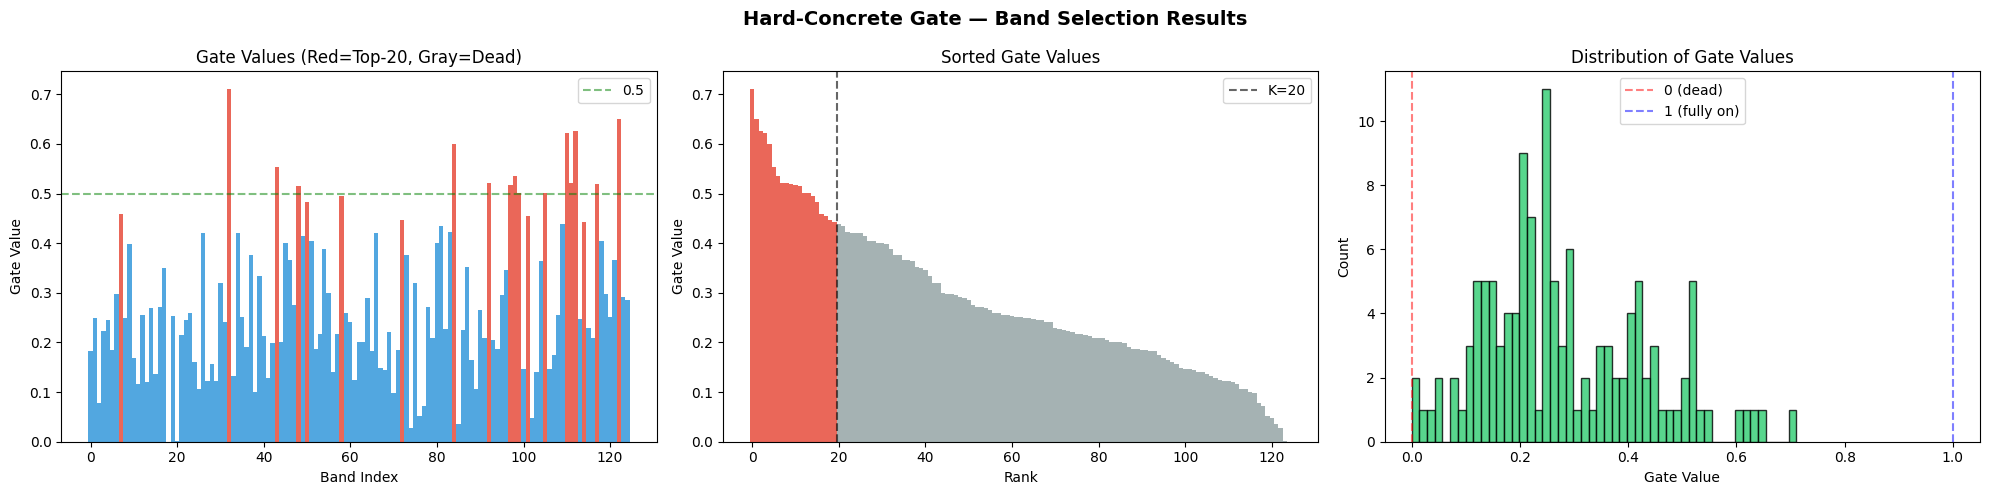

📊 Plot saved to D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints


In [41]:
# ===============================================================
# 🎯 Top-K Band Analysis + Visualization
# ===============================================================
import matplotlib.pyplot as plt

K = TARGET_K

with torch.no_grad():
    gate_vals = model.gate().cpu().numpy()  # (125,)

# --- Sắp xếp ---
sorted_idx = np.argsort(gate_vals)[::-1]
topK_idx   = sorted_idx[:K]
topK_vals  = gate_vals[topK_idx]

# --- Thống kê ---
active_bands = (gate_vals > 0).sum()
dead_bands   = (gate_vals == 0).sum()

print(f"{'='*70}")
print(f"  HARD-CONCRETE GATE ANALYSIS")
print(f"{'='*70}")
print(f"  Active bands (gate > 0): {active_bands}")
print(f"  Dead bands   (gate = 0): {dead_bands}")
print(f"  Gate sum  : {gate_vals.sum():.2f}")
print(f"  Gate mean : {gate_vals.mean():.4f}")
print(f"  Gate std  : {gate_vals.std():.4f}")
print(f"  Gate min  : {gate_vals.min():.4f}  (band {gate_vals.argmin()})")
print(f"  Gate max  : {gate_vals.max():.4f}  (band {gate_vals.argmax()})")
print(f"{'='*70}")
print(f"\n  TOP-{K} BANDS:")
print(f"  {'Rank':>4s}  {'Band':>6s}  {'Gate Value':>12s}  {'Status':>8s}")
print(f"  {'-'*34}")
for rank, (band, val) in enumerate(zip(topK_idx, topK_vals), 1):
    status = "ON" if val > 0 else "OFF"
    bar = "█" * int(val * 20)
    print(f"  {rank:>4d}  {band:>6d}  {val:>12.6f}  {status:>8s}  {bar}")

print(f"\n  📌 Top-{K} band indices (sorted): {sorted(topK_idx.tolist())}")

# ===============================================================
# Visualization
# ===============================================================
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# (a) Gate values per band — highlight top-K
ax = axes[0]
colors = ['#e74c3c' if i in topK_idx else ('#3498db' if gate_vals[i] > 0 else '#bdc3c7')
          for i in range(len(gate_vals))]
ax.bar(range(len(gate_vals)), gate_vals, color=colors, alpha=0.85, width=1.0)
ax.set_xlabel("Band Index"); ax.set_ylabel("Gate Value")
ax.set_title(f"Gate Values (Red=Top-{K}, Gray=Dead)")
ax.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='0.5')
ax.legend()

# (b) Sorted gate values
ax = axes[1]
sorted_vals = gate_vals[sorted_idx]
colors_s = ['#e74c3c' if i < K else ('#95a5a6' if sorted_vals[i] > 0 else '#ddd')
            for i in range(len(sorted_vals))]
ax.bar(range(len(sorted_vals)), sorted_vals, color=colors_s, alpha=0.85, width=1.0)
ax.axvline(x=K - 0.5, color='black', linestyle='--', alpha=0.6, label=f'K={K}')
ax.set_xlabel("Rank"); ax.set_ylabel("Gate Value")
ax.set_title(f"Sorted Gate Values")
ax.legend()

# (c) Histogram of gate values
ax = axes[2]
ax.hist(gate_vals, bins=50, color='#2ecc71', edgecolor='black', alpha=0.8)
ax.set_xlabel("Gate Value"); ax.set_ylabel("Count")
ax.set_title("Distribution of Gate Values")
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='0 (dead)')
ax.axvline(x=1, color='blue', linestyle='--', alpha=0.5, label='1 (fully on)')
ax.legend()

plt.suptitle("Hard-Concrete Gate — Band Selection Results", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "hardconcrete_topK_analysis.png"), dpi=150, bbox_inches='tight')
plt.show()
print(f"📊 Plot saved to {CHECKPOINT_DIR}")

In [42]:
# ===============================================================
# 💾 Save Top-K band info to JSON
# ===============================================================
import json

topK_info = {
    "method": "Hard-Concrete L0 Gate (Louizos et al., ICLR 2018)",
    "K": int(K),
    "topK_band_indices": sorted(topK_idx.tolist()),
    "topK_band_indices_by_importance": topK_idx.tolist(),
    "topK_gate_values": topK_vals.tolist(),
    "active_bands_count": int(active_bands),
    "dead_bands_count": int(dead_bands),
    "gate_stats": {
        "sum":  float(gate_vals.sum()),
        "mean": float(gate_vals.mean()),
        "std":  float(gate_vals.std()),
        "min":  float(gate_vals.min()),
        "max":  float(gate_vals.max()),
    },
    "all_gate_values": gate_vals.tolist(),
    "training_config": {
        "epochs": EPOCHS,
        "lambda_l0": LAMBDA_L0,
        "backbone_lr": LR,
        "gate_lr": GATE_LR,
        "best_val_acc": best_acc,
        "best_epoch": best_epoch,
    },
    "source_checkpoint": CKPT_PATH,
}

topK_info_path = os.path.join(CHECKPOINT_DIR, "hardconcrete_topK_band_info.json")
with open(topK_info_path, "w") as f:
    json.dump(topK_info, f, indent=2)

print(f"✅ Saved to: {topK_info_path}")
print(f"\n{'='*60}")
print(f"  📌 KẾT QUẢ CUỐI CÙNG")
print(f"{'='*60}")
print(f"  Best Val Acc : {best_acc:.4f} (epoch {best_epoch})")
print(f"  Active bands : {active_bands} / 125")
print(f"  Top-{K} bands : {sorted(topK_idx.tolist())}")
print(f"{'='*60}")
print(f"\n  Dùng cho pipeline tiếp theo:")
print(f"  SELECTED_BANDS = {sorted(topK_idx.tolist())}")

✅ Saved to: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\hardconcrete_topK_band_info.json

  📌 KẾT QUẢ CUỐI CÙNG
  Best Val Acc : 0.6724 (epoch 30)
  Active bands : 124 / 125
  Top-20 bands : [7, 32, 43, 48, 50, 58, 72, 84, 92, 97, 98, 99, 101, 105, 110, 111, 112, 114, 117, 122]

  Dùng cho pipeline tiếp theo:
  SELECTED_BANDS = [7, 32, 43, 48, 50, 58, 72, 84, 92, 97, 98, 99, 101, 105, 110, 111, 112, 114, 117, 122]


---
## 🔧 Tuning Guide

Nếu kết quả chưa tốt, thử điều chỉnh:

| Vấn đề | Giải pháp |
|---|---|
| Quá ít band bị tắt → chưa sparse | Tăng `LAMBDA_L0` (0.2, 0.5, 1.0) |
| Quá nhiều band bị tắt → acc giảm | Giảm `LAMBDA_L0` (0.05, 0.01) |
| Gate chưa phân hóa (std nhỏ) | Tăng `GATE_LR` (5e-2), train thêm epochs |
| Overfitting (train acc >> val acc) | Tăng `WD`, thêm augmentation, giảm `EPOCHS` |

### Lưu ý:
- Nên **monitor `active_bands`** — khi nó ổn định quanh TARGET_K thì gate đã converge
- Nếu gate tắt quá nhanh (epoch đầu đã <20 bands), **giảm `LAMBDA_L0`**
- Cosine scheduler giúp gate ổn định cuối training (lr giảm dần)
- Checkpoint saved chỉ khi val_acc cải thiện → đảm bảo model tốt nhất

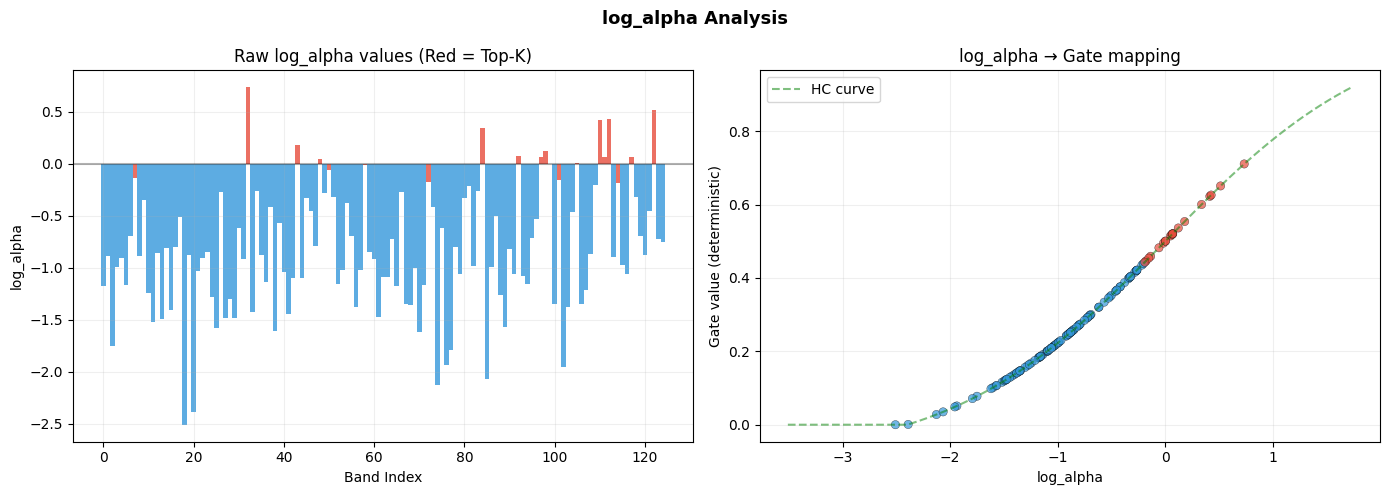


log_alpha range: [-2.509, 0.734]
Bands với log_alpha > 0 (ưu tiên bật) : 14
Bands với log_alpha < 0 (ưu tiên tắt) : 111
Bands với log_alpha < -5 (gần chắc tắt): 0
Bands với log_alpha > 5  (gần chắc bật): 0


In [43]:
# ===============================================================
# 🔍 Bonus: log_alpha analysis (raw learnable parameters)
# ===============================================================

log_alpha = model.log_alpha.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) log_alpha values
ax = axes[0]
colors_la = ['#e74c3c' if i in topK_idx else '#3498db' for i in range(len(log_alpha))]
ax.bar(range(len(log_alpha)), log_alpha, color=colors_la, alpha=0.8, width=1.0)
ax.set_xlabel("Band Index"); ax.set_ylabel("log_alpha")
ax.set_title("Raw log_alpha values (Red = Top-K)")
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.grid(True, alpha=0.2)

# (b) Relationship: log_alpha → gate value
ax = axes[1]
ax.scatter(log_alpha, gate_vals, c=colors_la, alpha=0.7, edgecolors='k', linewidth=0.3)
ax.set_xlabel("log_alpha"); ax.set_ylabel("Gate value (deterministic)")
ax.set_title("log_alpha → Gate mapping")
# Plot the theoretical curve
x_range = np.linspace(log_alpha.min() - 1, log_alpha.max() + 1, 200)
y_curve = np.clip(1/(1+np.exp(-x_range)) * (1.1 - (-0.1)) + (-0.1), 0, 1)
ax.plot(x_range, y_curve, 'g--', alpha=0.5, label='HC curve')
ax.legend()
ax.grid(True, alpha=0.2)

plt.suptitle("log_alpha Analysis", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Phân tích thêm
print(f"\nlog_alpha range: [{log_alpha.min():.3f}, {log_alpha.max():.3f}]")
print(f"Bands với log_alpha > 0 (ưu tiên bật) : {(log_alpha > 0).sum()}")
print(f"Bands với log_alpha < 0 (ưu tiên tắt) : {(log_alpha < 0).sum()}")
print(f"Bands với log_alpha < -5 (gần chắc tắt): {(log_alpha < -5).sum()}")
print(f"Bands với log_alpha > 5  (gần chắc bật): {(log_alpha > 5).sum()}")